# AI Fall 2022 - A4 - Decision Tree


## Practical Question - Decision Tree (25 + 5 points)
In this question you will first write a program to find an appropriate order of features for training a decision tree based on information gain. In the second part, you will use existing implementations to train and tune a classifier using GridSearch on the given dataset. And try to finish this in <15 mins.

### Import
Import the libraries you need in the next cell.

In [1]:
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.model_selection import train_test_split #train_test_split function
from sklearn import metrics #accuracy calculation
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import numpy as np

### Part A (20 points)
Consider the following dataframe and answer the following questions:

In [2]:
df = pd.DataFrame({
    'Race': [1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'Sex': [1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0],
    'Age': [43.0, 72.0, 4.0, 59.0, 34.0, 55.0, 41.0, 39.0, 6.0, 77.0, 67.0, 35.0, 45.0, 39.0, 32.0, 57.0, 99.0, 68.0, 47.0, 28.0],
    'BMI': [25.803, 33.394, 20.278, 32.918, 30.743, 37.734, 23.725, 20.722, 19.452, 22.044, 17.481, 18.918, 28.578, 19.214, 23.562, 23.446, 21.872, 20.691, 25.471, 25.82],
    'Smoker': [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    'Label': [False, True, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, True, False],
})

df.head()

,Race,Sex,Age,BMI,Smoker,Label
0,1.0,1.0,43.0,25.803,1.0,False
1,2.0,2.0,72.0,33.394,0.0,True
2,1.0,2.0,4.0,20.278,1.0,False
3,1.0,2.0,59.0,32.918,0.0,False
4,1.0,2.0,34.0,30.743,1.0,False


#### QA.1 (10 points)
Complete the following function that calculates and returns the list of features based on their information gain.

In [3]:
def find_entropy(df):

    true_num=len(df[(df['Label']==True)])
    false_num=len(df[(df['Label']==False)])
    if(true_num==0 and false_num==0):
       return 0
    else :     
      pos_prb=(true_num)/(true_num+false_num) if true_num!=0 else 1 
      neg_prb=(false_num)/(true_num+false_num) if false_num!=0 else 1 
      #----------------------
      entropy=-(pos_prb*np.log2(pos_prb) +neg_prb*np.log2(neg_prb))
      return entropy

In [4]:
def IG_cal(input:pd.DataFrame,attribute):
    
    initial_entropy=find_entropy(input)
    #---------------------
    domain=input[attribute].unique()
    is_bool=True if len(domain)==2 else False

    if(is_bool):
      splited1=input[(input[attribute]==domain[0])]
      num1=len(splited1)
      splited2=input[(input[attribute]==domain[1])]
      num2=len(splited2)
      #----------------------
      coef1=(num1/(num1+num2))
      coef2=(num2/(num1+num2))
      entropy_first=coef1*find_entropy(splited1)
      entropy_second=coef2*find_entropy(splited2)
      #---------------------
      total_entropy=entropy_first+entropy_second

      return initial_entropy-total_entropy,'bool'

    if(not is_bool):
    
      domain=list(df[attribute].unique())
      #--------------------
      sorted_value=sorted(domain)
      adjacent_values=[np.mean(sorted_value[i:i+2]) for i in range(len(sorted_value)-1)]
      #--------------------
      best_thresh=0
      least_entropy=1
      for threshold in adjacent_values:

          splited1=input[(input[attribute]<=threshold)]
          num1=len(splited1)
          splited2=input[(input[attribute]>threshold)]
          num2=len(splited2)
          #----------------------
          coef1=(num1/(num1+num2))
          coef2=(num2/(num1+num2))
          entropy_first=coef1*find_entropy(splited1)
          entropy_second=coef2*find_entropy(splited2)
          #---------------------
          total_entropy=entropy_first+entropy_second
          #--------------------
          best_thresh= threshold if total_entropy<least_entropy else best_thresh
          least_entropy=total_entropy if total_entropy<least_entropy else least_entropy

      return initial_entropy-least_entropy,best_thresh          

In [5]:
def feature_order(X_data, y_data):
    '''
    Calculate the best feature order
    for training a decision tree based on
    information gain.
    Input:
        X_data (pd.DataFrame) contains data features
        y_data (pd.Series) contains the labels
    Output:
        order (list[str]): The `X_data` columns in the correct order
    '''
    order = list(X_data)
    # Your code here

    IG_List=[]
    threshold_list=[]
    #------------------------
    for attribute in order:
        IG,threshold=IG_cal(df,attribute)
        IG_List.append(IG)
        threshold_list.append(threshold)
    #---------------------------
    order = [x for _,x in sorted(zip(IG_List,order),reverse=True)] 
    threshold_list=  [x for _,x in sorted(zip(IG_List,threshold_list),reverse=True)] 
    IG_List=sorted(IG_List, reverse=True) 
    
    return order,IG_List,threshold_list


sorted_features,ig_order,threshold_list=feature_order(df.columns[:-1], df.Label)
print(f"sorted_features :{sorted_features} \n ---------")
print(f"information gain based on order of features :{ig_order}\n ----------")
print(f"threshold_list :{threshold_list }")

sorted_features :['Age', 'BMI', 'Race', 'Smoker', 'Sex'] 
 ---------
information gain based on order of features :[0.2759438679601623, 0.26899559358928116, 0.03690791540384364, 0.03051882909598158, 0.0018149273570102764]
 ----------
threshold_list :[46.0, 33.156, 'bool', 'bool', 'bool']


#### QA.2 (5 points)
What are some of the effective approaches to prevent the tree from overfitting? (three approaches)

<font color=#183364>
    <i>
        Answer.
        <ol>
            <li> Pre-Pruning : avoid expanding depth of tree, based in a threshold  </li> 
            <li> Post-Pruning : considers the subtrees of the full tree and uses a cross-validated metric to score each of the subtrees. To clarify, we are using subtree to mean a tree with the same root as the original tree but without some branches. </li>
            <li> Random Forest : The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees. 
Random Forest has multiple decision trees as base learning models. We randomly perform row sampling and feature sampling from the dataset forming sample datasets for every model</li>
        </ol>
    </i>
</font>

#### QA.3 (5 points)
About the `Age` feature which is an integer-valued input attribute, how can a tree utilize it for classification? Write a small piece of code to find the answer for this specific column.

<font color=#183364>
    <i>
        Answer : for continues variables, it's good to sort the observed data and then make a new list, that is average of adjacency elements. then we itterate all over this adjacency array and set evaulate model performance according to element of adjacency array elements . the one with biggest accuracy is the best cutoff point
    </i>
</font>

In [6]:
# Your code here
#--------------------
initial_entropy=find_entropy(df)
domain=list(df['Age'].unique())
#--------------------
sorted_value=sorted(domain)
adjacent_values=[np.mean(sorted_value[i:i+2]) for i in range(len(sorted_value)-1)]
#--------------------
best_thresh=0
least_entropy=1
for threshold in adjacent_values:

    splited1=df[(df['Age']<=threshold)]
    num1=len(splited1)
    splited2=df[(df['Age']>threshold)]
    num2=len(splited2)
    #----------------------
    coef1=(num1/(num1+num2))
    coef2=(num2/(num1+num2))
    entropy_first=coef1*find_entropy(splited1)
    entropy_second=coef2*find_entropy(splited2)
    #---------------------
    total_entropy=entropy_first+entropy_second
    #--------------------
    best_thresh= threshold if total_entropy<least_entropy else best_thresh
    least_entropy=total_entropy if total_entropy<least_entropy else least_entropy
#--------------------------------
print(f"best_threshold :{best_thresh}")
print(f"best information gain : {initial_entropy-least_entropy}")

best_threshold :46.0
best information gain : 0.2759438679601623


### Part B (10 points)
In this part you will learn more about [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and use it to train a classifier and tune its parameters.

#### QB.1 (5 points)
For measuring the _accuracy_ of your models, choose a subset of the given dataset as your validation set (Check out [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

In [7]:
feature_cols = ['Race', 'Sex', 'Age', 'BMI','Smoker']

In [49]:
# Your code here
## Split the dataset
X = df[feature_cols] # Features
y = df.Label # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [50]:
# Your code here
## Set your own hyperparameters below, such as:
dt_hyperparams = {
    'min_samples_split': 2,
    'criterion': 'gini' ,
    'max_depth' : 1
}

## Train the model and check its performance
clf = DecisionTreeClassifier(class_weight=None, criterion=dt_hyperparams['criterion'], max_depth=dt_hyperparams['max_depth'],
 max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
 min_samples_split=dt_hyperparams['min_samples_split'])
#-------------------------
clf = clf.fit(X_train,y_train)
#-------------------------
y_pred = clf.predict(X_test)

# measure accuracy

In [51]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


#### QB.2 (5 points)
Take a look at customizable and potentially useful input params of the model, define a range for each of their values, and use GridSearch (Feel free to implement/[import](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) it) and find a set of hyperparametetrs that work best among your candidates.

In [52]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [1,2,3,4,5,6],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1024),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=True)

In [53]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.1, criterion='entropy', max_depth=3,
                       max_features='auto', random_state=1024)

In [54]:
y_pred = final_model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


#### QB.3 (5 extra points)
Visualize the tree splits and interpret it (Hint: Search about `IPython.display.Image`, `pydotplus`, `StringIO`, and `export_graphviz`).

<font color=#183364>
    <i>
        interpretation:
        <ol>
            in each step, our tree try to find classes with least entropy. so our model start with expanding BMI feature. this method continues until we reach leaves with zero entropy  </li> 
          
    
</font>

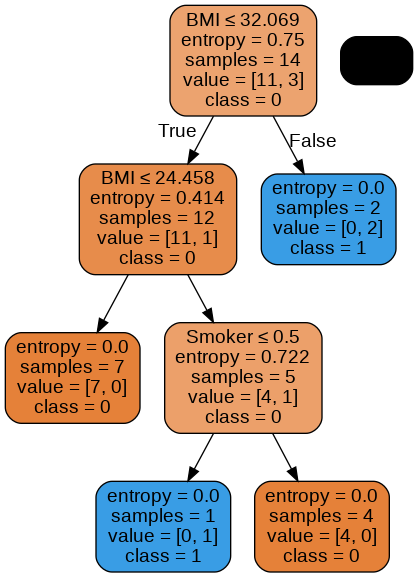

In [57]:
final_model.fit(X_train,y_train)
dot_data = StringIO()
export_graphviz(final_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())